# TNM112 -- Lab 2

### Data generation
Look through the "data_generator.py" code to understand how the dataset is generated and plotted.

A dataset can be generated with a randomly selected subset of training images, and with a specified fraction used to formulate a validation set. Here, we use the MNIST dataset of handwritten digits.

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (54000, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


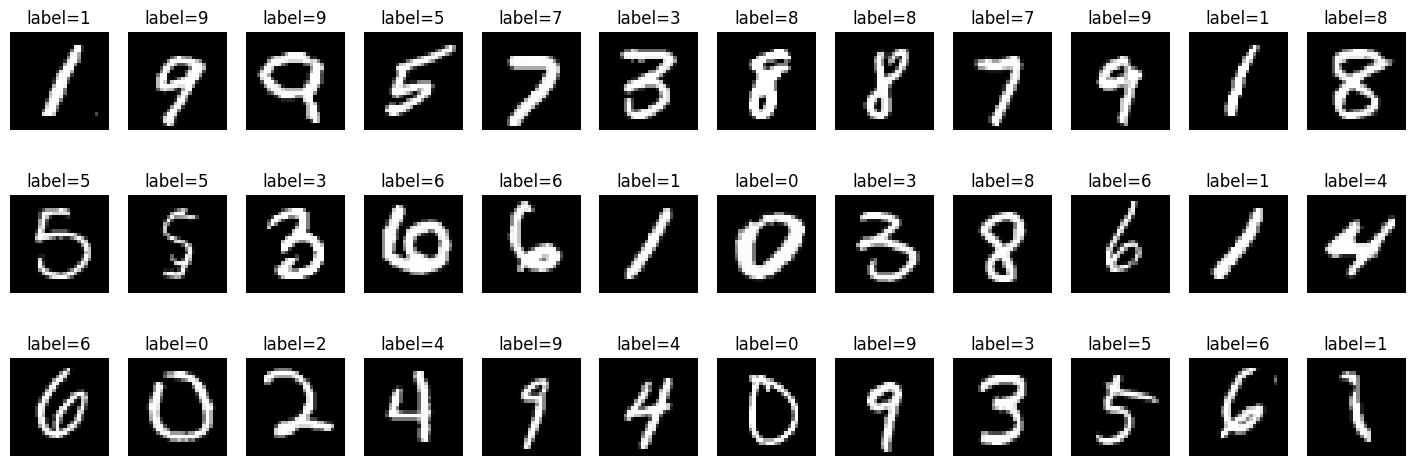

<Figure size 640x480 with 0 Axes>

In [52]:
import data_generator

data = data_generator.DataGenerator()
data.generate(dataset='mnist', N_valid=0.1)
data.plot()

### Keras CNN
A small CNN in Keras, trained with cross-entropy loss

We use the functions in 'util.py' to evaluate the model and plot the training progress.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         3,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,266 (16.66 KB)

 Trainable params: 4,266 (16.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6562 - loss: 1.1406 - val_accuracy: 0.9303 - val_loss: 0.2297
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9415 - loss: 0.1957 - val_accuracy: 0.9558 - val_loss: 0.1475
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9624 - loss: 0.1305 - val_accuracy: 0.9650 - val_loss: 0.1163
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9682 - loss: 0.1078 - val_accuracy: 0.9685 - val_loss: 0.1032
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9728 - loss: 0.0945 - val_accuracy: 0.9717 - val_loss: 0.0904
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9747 - loss: 0.0832 - val_accuracy: 0.9740 - val_loss: 0.0833
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9777 - loss: 0.0751 - val_accuracy: 0.9757 - val_loss: 0.0800
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9787 - loss: 0.0695 - val_accuracy: 0.

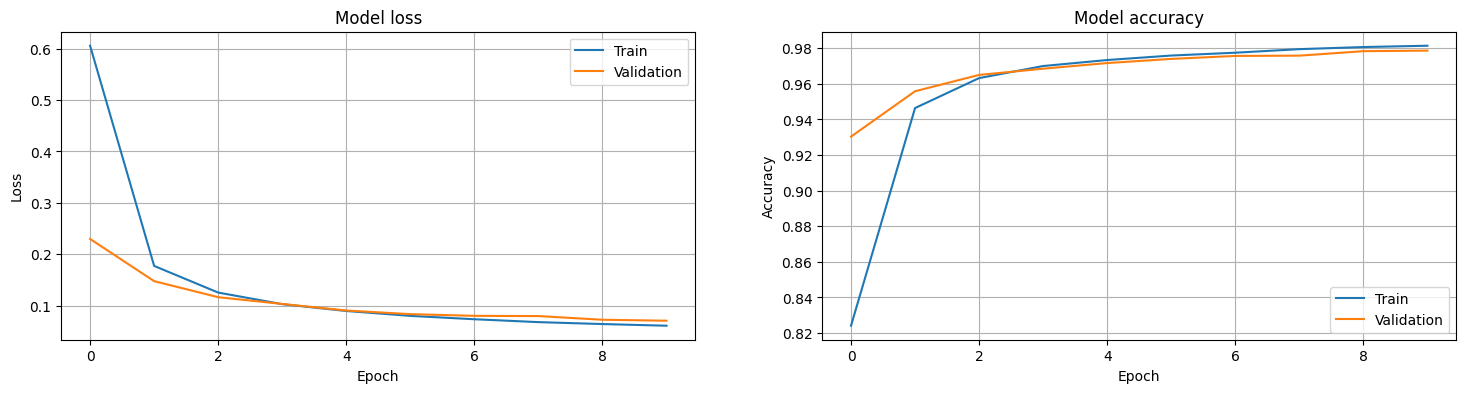

In [53]:
from tensorflow import keras
from tensorflow.keras import layers
import util

keras.backend.clear_session()

model = keras.Sequential()
model.add(layers.InputLayer(input_shape=data.x_train.shape[1:]))
model.add(layers.Conv2D(4, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(data.K, activation='softmax'))
model.summary()

opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
log = model.fit(data.x_train, data.y_train_oh, batch_size=128, epochs=10, 
                validation_data=(data.x_valid, data.y_valid_oh), verbose=True)

util.evaluate(model, data, final=True)
util.plot_training(log)

In [54]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         3,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,800 (50.00 KB)

 Trainable params: 4,266 (16.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,534 (33.34 KB)

In [55]:
for l in range(5):
    print(model.layers[l].name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten


### Our CNN

#### Task 1
Implement the following functions in cnn.py: 'activation', 'conv2d_layer', 'pool2d_layer', 'flatten_layer', 'dense_layer', and 'evaluate'. Additionally, compute the number of weights in the model, in the function 'setup_model'.

For the 'activation' and 'dense_layer' functions you can use code that you wrote in Lab 1. For the 'evaluate' function you can use the code from Lab 1 for the accuracy. However, now we have trained with the cross-entropy loss, so you should evaluate this loss function through our CNN.

When you have finished the implementation, you should be able to run this code and get the same result as with the Keras model above. However, our code is not optimized, nor parallelized, so it will be rather slow to process the full dataset. In order to facilitate comparisons when you implement the functions, please have a look in the next cell below. 

In [68]:
import importlib
import cnn
importlib.reload(cnn)

# Get the weight matrices and biases of the trained Keras model
W, b, lname = util.get_weights(model)
print(lname)

# This is our implementation of a CNN, which we set to use the dataset we generated
cnn = cnn.CNN(data, verbose=True)

# Assign the weights and biases to the CNN and specify the activation function
cnn.setup_model(W, b, lname, activation='relu')

# Evaluate the model (accuracy on the training and test data)
cnn.evaluate()

['conv', 'pool', 'conv', 'pool', 'flatten', 'dense']
Number of model weights:  4266
Model performance:
sample 0 of 54000
sample 1000 of 54000
sample 2000 of 54000
sample 3000 of 54000
sample 4000 of 54000
sample 5000 of 54000
sample 6000 of 54000
sample 7000 of 54000
sample 8000 of 54000
sample 9000 of 54000
sample 10000 of 54000
sample 11000 of 54000
sample 12000 of 54000
sample 13000 of 54000
sample 14000 of 54000
sample 15000 of 54000
sample 16000 of 54000
sample 17000 of 54000
sample 18000 of 54000
sample 19000 of 54000
sample 20000 of 54000
sample 21000 of 54000
sample 22000 of 54000
sample 23000 of 54000
sample 24000 of 54000
sample 25000 of 54000
sample 26000 of 54000
sample 27000 of 54000
sample 28000 of 54000
sample 29000 of 54000
sample 30000 of 54000
sample 31000 of 54000
sample 32000 of 54000
sample 33000 of 54000
sample 34000 of 54000
sample 35000 of 54000
sample 36000 of 54000
sample 37000 of 54000
sample 38000 of 54000
sample 39000 of 54000
sample 40000 of 54000
sample 4

### Evaluation of our CNN layers

#### Task 1
As part of the implementation of the different layers in 'cnn.py', you can use the below code to compare the output of a randomly initialized Keras model and our CNN, for a single image. This is fast to compute, which will be convenient to check that your layers are correctly implemented.

In [69]:
import numpy as np
import cnn
importlib.reload(cnn)

# Secify a test layer for comparison: 'conv', 'pool', 'flatten', or 'dense'
test_layer = 'conv'

keras.backend.clear_session()

# Keras model and input layer
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=data.x_train.shape[1:]))

# Test conv layer
#   - We apply normal initialization to the bias also,
#     otherwise it would be difficult to see the impact
#     of how you apply the bias (it is initialized to 0 by default)
if test_layer == 'conv':
    model.add(layers.Conv2D(4, kernel_size=(3, 3), 
                            activation='relu', padding='same',
                            bias_initializer='normal'))
    
    # You could also test to add a second convolutional layer, to check
    # that your network maps correctly from the output channels of the
    # previous layer, to the channels of this layer
    model.add(layers.Conv2D(4, kernel_size=(3, 3), 
                           activation='relu', padding='same',
                           bias_initializer='normal'))

# Test pooling layer
elif test_layer == 'pool':
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Test flattening layer
elif test_layer == 'flatten':
    model.add(layers.Flatten())

# Test dense layer
#   - We need to first flatten the image input to apply a dense layer
#   - Make sure that your flatten layer works before testing the dense layer
elif test_layer == 'dense':
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax',
                           bias_initializer='normal'))

# Test data point (you could select any other image if you want)
x = data.x_train[0]

# Keras prediction. We need ta add an extra axis, 
# since the model can run over multiple datapoints. We 
# would need this in our model also if we use used the
# 'feedforward' function instead of the 'feedforward_sample'
y1 = model.predict(x[np.newaxis,:,:,:], verbose=False)

# Prediction with our network
W, b, lname = util.get_weights(model)  # Get the Keras model weights
cnn = cnn.CNN(data)
cnn.setup_model(W, b, lname, activation='relu') # Assign weights to our model
y2 = cnn.feedforward_sample(x) # Feedforward of one single sample

print('Evaluation of %s layer:'%test_layer)

# Check that the dimensionality is correct. The Keras
# model will have an extra first dimension due to the
# batch processing
print('\tShape of Keras output:  ', y1.shape)
print('\tShape of our output:    ', y2.shape)

# Print the absolute sum of output from the Keras
# model and our model. These should be the same if the
# implementation is correct
print('\tAbs sum of Keras model: ', np.sum(np.abs(y1)))
print('\tAbs sum of our model:   ', np.sum(np.abs(y2)))

# Print the absolute difference between the Keras
# model and our model. This should be very close
# to 0 if your implementation is correct. It could be
# a very minor difference due to numerical differences 
# (e.g., difference in precision used)
print('\tAbs difference:         ', np.sum(np.abs(y1-y2)))

Number of model weights:  188
Evaluation of conv layer:
	Shape of Keras output:   (1, 28, 28, 4)
	Shape of our output:     (28, 28, 4)
	Abs sum of Keras model:  226.54933
	Abs sum of our model:    226.54934559242594
	Abs difference:          2.7145816145573987e-05


### MNIST with limited training data
#### Task 2
In this experiment, we select a random subset from MNIST, with only 128 images. This is a very minimal dataset, but it is interesting to see how overfitting can be prevented with regularization strategies.

Your task is to expand the given network with different regularization strategies. You are free to choose which combination of strategies you want to use, for example augmentation layers, dropout, weight decay, batch normalization, etc. You can also expand the network with more layers, strided convolutions, or add skip-connections to facilitate optimization. Moreover, you can experiment with the number of training epochs and the batch size.

Also, note that now we have specified the Keras network in a sligthly different way. We explicitly formulate the input and output to the different layers. One motiviation for this is that it is easier if we want to, e.g., add skip-connections (checkout the layers.Add() layer in Keras).

During your development, you test the performance on the validation set (util.evaluate with the flag final=False). When you have found a good setup, run evaluation on the test set (final=True). Do this for at least 5 runs and report the average and the variance across models. Since the subset of 128 images is randomly selected and the optimization is stochastic, you will get slightly different values each time. Thus, averaging is important to get a robust indication of your model's performance. You can do this manually, or you can setup a for-loop to run a sequence of trainings, where you log the evaluation results for each model.

For the final results, you should aim at having an average accuracy of at least 90% (which is quite good considering that we are only training on 128 images).

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,138 (668.51 KB)

 Trainable params: 171,138 (668.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1562 - loss: 2.5667
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1406 - loss: 2.5529
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1094 - loss: 2.5539
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1484 - loss: 2.5586
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1484 - loss: 2.5429
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1406 - loss: 2.5274
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1641 - loss: 2.5162
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1406 - loss: 2.5130
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1797 - loss: 2.4952
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 0.1719 - loss: 2.4855 - val_accuracy: 0.1640 - val_loss: 2.5062
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1875 - loss: 2.4753
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━

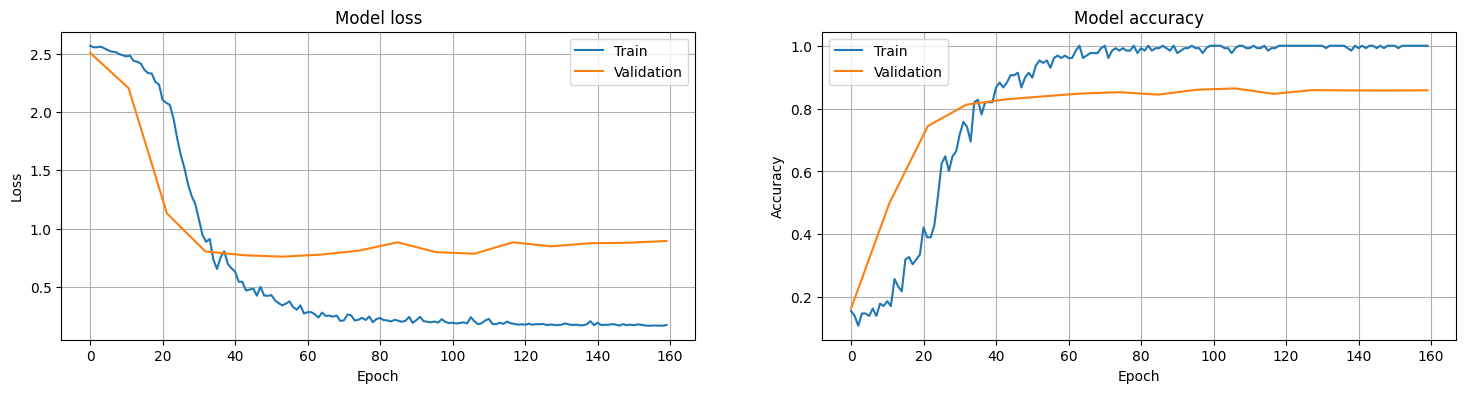

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,138 (668.51 KB)

 Trainable params: 171,138 (668.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1172 - loss: 2.5677
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1406 - loss: 2.5631
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2109 - loss: 2.5412
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1484 - loss: 2.5370
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1719 - loss: 2.5091
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2031 - loss: 2.4956
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1719 - loss: 2.5060
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1641 - loss: 2.5159
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1641 - loss: 2.4756
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.1719 - loss: 2.4795 - val_accuracy: 0.1132 - val_loss: 2.5230
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1641 - loss: 2.4616
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━

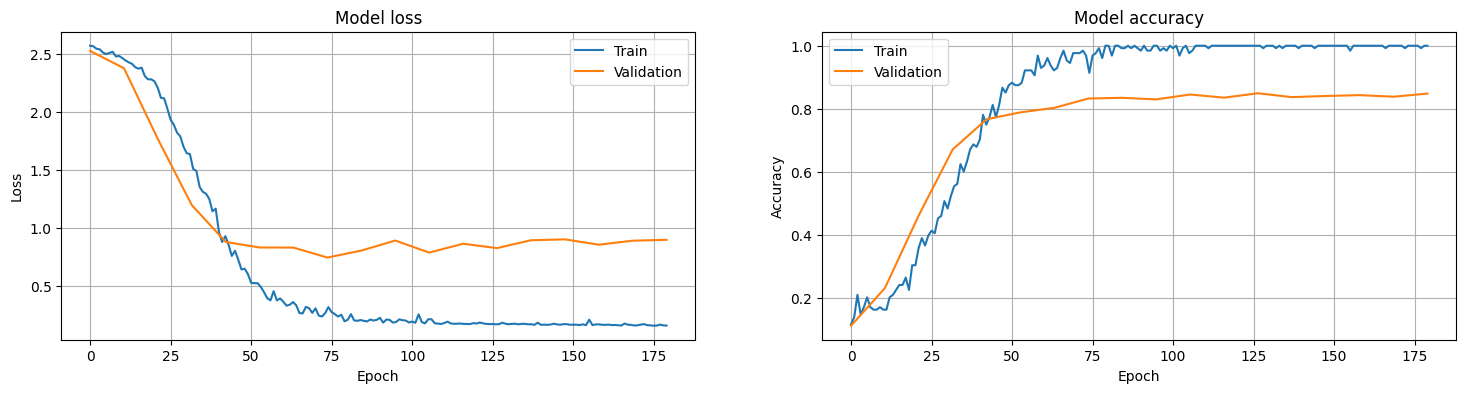

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,138 (668.51 KB)

 Trainable params: 171,138 (668.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1094 - loss: 2.5748
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1797 - loss: 2.5595
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2109 - loss: 2.5354
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1797 - loss: 2.5105
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1562 - loss: 2.4984
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1797 - loss: 2.4955
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1875 - loss: 2.4683
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1953 - loss: 2.4701
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2266 - loss: 2.4410
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step - accuracy: 0.2188 - loss: 2.4437 - val_accuracy: 0.1035 - val_loss: 2.5242
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2031 - loss: 2.4147
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━

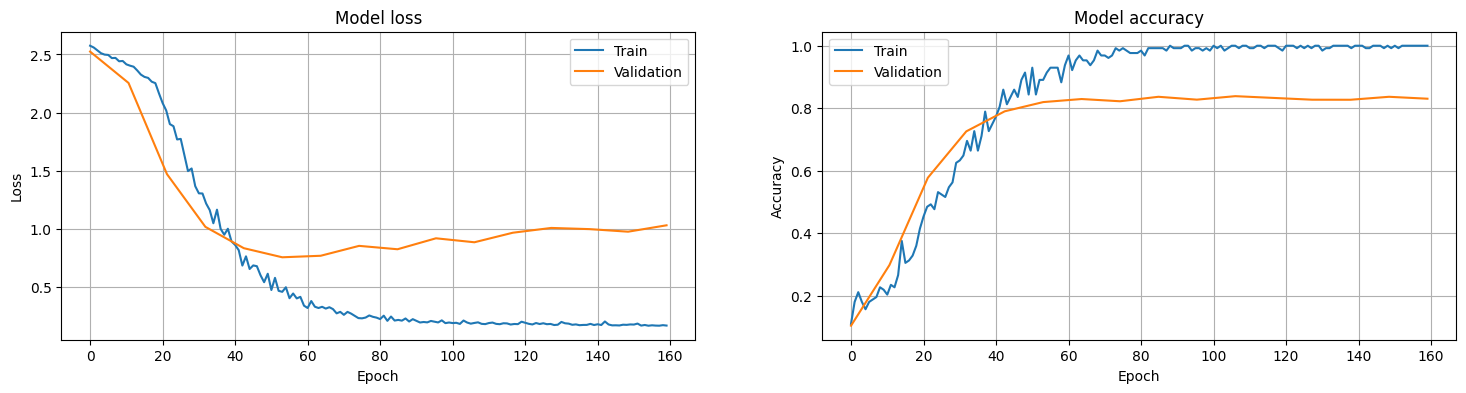

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,138 (668.51 KB)

 Trainable params: 171,138 (668.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0781 - loss: 2.5756
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1250 - loss: 2.5668
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1641 - loss: 2.5534
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1641 - loss: 2.5452
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2266 - loss: 2.5336
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1562 - loss: 2.5331
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1641 - loss: 2.5225
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1094 - loss: 2.5068
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1641 - loss: 2.4906
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - accuracy: 0.1641 - loss: 2.4812 - val_accuracy: 0.1602 - val_loss: 2.5277
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2031 - loss: 2.4833
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━

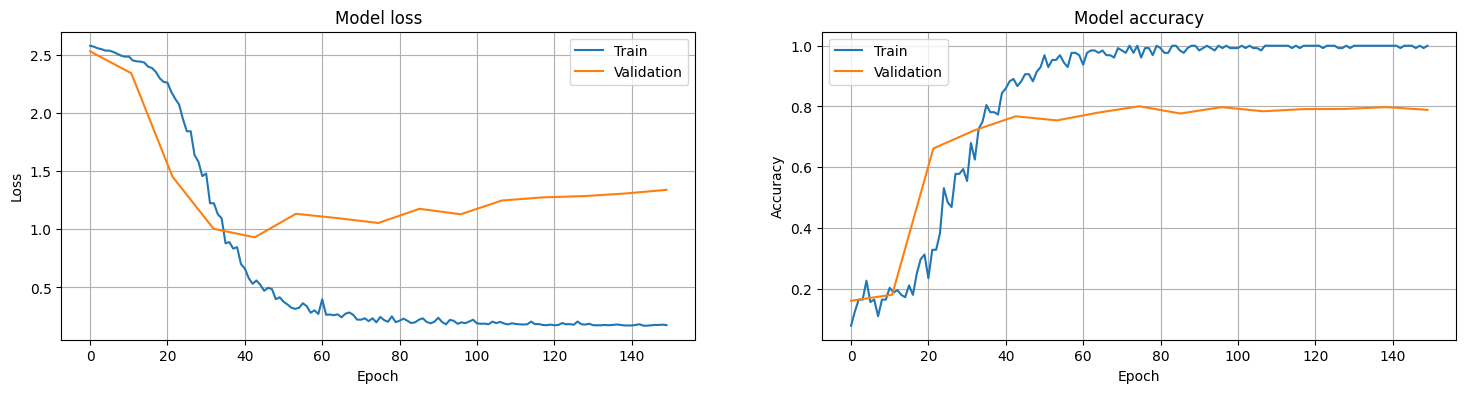

Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (128, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,138 (668.51 KB)

 Trainable params: 171,138 (668.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0781 - loss: 2.5769
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1328 - loss: 2.5652
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1406 - loss: 2.5563
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1562 - loss: 2.5495
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1406 - loss: 2.5448
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1250 - loss: 2.5423
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1406 - loss: 2.5173
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1250 - loss: 2.5233
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0938 - loss: 2.5095
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - accuracy: 0.1562 - loss: 2.5000 - val_accuracy: 0.0917 - val_loss: 2.5320
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1250 - loss: 2.4994
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━

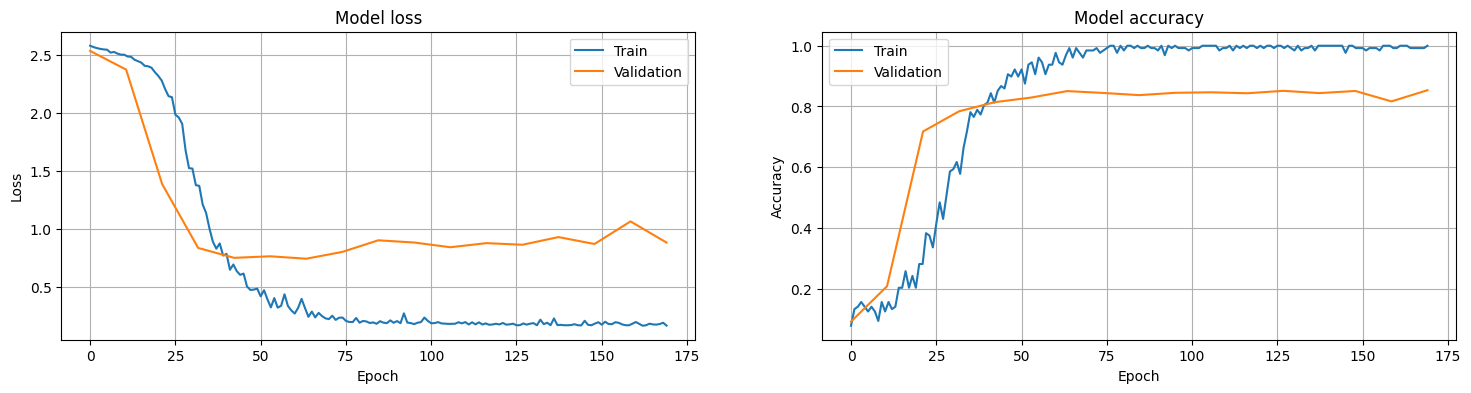

Model performance:
	Train loss:          0.1778
	Train accuracy:      100.00
	Test loss:           0.7124
	Test accuracy:       86.37


In [ ]:
from keras import regularizers
from keras.callbacks import EarlyStopping


# A block of convolutional layers followed by max pooling
def conv_block(x, N, channels, kernel_size, activation, padding='same', weight_decay=0.001):
    for i in range(N):
        x = layers.Conv2D(channels, kernel_size=kernel_size, activation=activation, padding=padding, kernel_regularizer=regularizers.l2(weight_decay))(x)
        #x = layers.BatchNormalization()(x) 
    return layers.MaxPooling2D(pool_size=(2, 2))(x)
    
epochs = 600
batch_size = 128

# ------ Added changes to get acc: 90.25% -------
# * Added weight_decay, 0.001 and 0.0005
# * Changed epochs from 200 -> 300
# * Added Drop-out at 0.7

# For setting up averaging over multiple training runs
K = 5
acc = np.zeros((K,2))
for k in range(K):

    # MNIST with 128 randomly selected training images
    data = data_generator.DataGenerator()
    data.generate(dataset='mnist', N_train=128)

    keras.backend.clear_session()

    x      = layers.Input(shape=data.x_train.shape[1:])
    conv1  = conv_block(x, N=2, channels=8, kernel_size=(3,3), activation='relu', padding='same')
    conv2  = conv_block(conv1, N=2, channels=16, kernel_size=(3,3), activation='relu', padding='same')
    conv3  = conv_block(conv2, N=2, channels=32, kernel_size=(3,3), activation='relu', padding='same')

    flat1  = layers.Flatten()(conv3)

    dense1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(flat1)
    dense1 = layers.Dropout(0.7)(dense1) # Add dropout (50% dropout rate)

    y = layers.Dense(data.K, activation='softmax')(dense1)

    model = keras.models.Model(inputs=x, outputs=y)
    model.summary()

    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss (or 'val_accuracy' if you want to monitor accuracy)
                                  patience=10,         # Number of epochs with no improvement after which training will be stopped
                                  restore_best_weights=True)  # Whether to restore model weights from the best epoch or the final weights

    log = model.fit(data.x_train, data.y_train_oh, batch_size=batch_size, epochs=epochs, 
                    validation_data=(data.x_valid, data.y_valid_oh), validation_freq=10,  # We don't need to evaluate at each epoch
                    verbose=True, callbacks=[early_stopping])

    util.evaluate(model, data, final=False)
    util.plot_training(log)

# When you are finished with hyper-parameter tuning, you should evaluate
# your model on the test set, and average over 5 trainings. If you want
# to do this automatically, you can setup a foor loop and store each evaluation
    acc[k,:] = util.evaluate(model, data, final=True)

### Tumor classification in digital pathology
#### Task 3
In this task, we will look at a more difficult task, using the PatchCamelyon dataset. This contains tissue samples from breast lymph nodes, which could either be healthy or contain tumor tissue, i.e. this is a binary classification problem. For this reason, it is valuable to also evaluate the AU-ROC, which can be passed to Keras as an evaluation metric, 'AUC'.

You are provided with the training and validation set. These have been cropped to 32x32 pixels, to make it a bit less resource demanding to train. The test set is also provided, but without labels.

Your task is to setup a Keras model to achieve the best possible performance on the validation set. You are free to choose how to do this, e.g., by means of regularization and network specifications. You can, for example, use your results from Task 2 as a starting point, but you should also think around how this problem differs from the MNIST classification. For example, in this case the orientation of images has no meaning, so you can randomly flip images both horizontally and vertically. You can also, e.g., explore augmentation by means of changing the image contrast and brightness.

When you are finished with your development, you should run the 'util.pred_test' (at the bottom of the cell), to produce a CSV file with predictions of the test set. The exported CSV file should be uploaded to the Kaggle challenge, as described in the lab information. You need to train the model and export a CSV file 5 times, in order to have a good estimate for your model's performance. There are no requirements on how well your model should perform, as long as it is well above random guessing (50% accuracy).

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import util
import data_generator
    
epochs = 10
batch_size = 128

# Load the PatchCamyleon dataset
# In this dataset, we don't have labels for the test set.
# Do your development by monitoring the validation performance,
# and when you are finished you will run predictions on the test
# set and produce a CSV file that you can upload to Kaggle.
data = data_generator.DataGenerator()
data.generate(dataset='patchcam')
data.plot()

keras.backend.clear_session()

# TODO: Build your network here
x = layers.Input(shape=data.x_train.shape[1:])
flat1  = layers.Flatten()(x)
y = layers.Dense(data.K, activation='softmax')(flat1)

model = keras.models.Model(inputs=x, outputs=y)
model.summary()

opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
log = model.fit(data.x_train, data.y_train_oh, batch_size=batch_size, epochs=epochs, 
                validation_data=(data.x_valid, data.y_valid_oh), validation_freq=1,
                verbose=True)

util.evaluate(model, data)
util.plot_training(log)

# TODO: When you have finished your model development, you should 
# run inference on the test set and export a CSV file that can be 
# uploaded to Kaggle
#util.pred_test(model, data, name='your_submission.csv')